# 03 Model Training

## Overview:
This notebook builds and trains three convolutional neural network (CNN) models for the **Animal Subspecies Classification** project:
1. ResNet50
2. DenseNet121
3. MobileNetV3

## Goals:
1. Load the preprocessed data and prepare it for training.
2. Build CNN models using transfer learning.
3. Train and evaluate the models using the training, validation, and testing datasets.
4. Save the trained models for future use.

## Outputs:
- Trained models saved in the `models/` directory.
- Metrics for model performance, including accuracy and loss on the test dataset.

In [1]:
# General imports
import os  # For file and directory operations
import time  # For tracking and logging training/evaluation time
import numpy as np  # For numerical computations
import csv  # For saving evaluation results to a CSV file

# TensorFlow/Keras imports
import tensorflow as tf  # Core TensorFlow library
from tensorflow.keras.models import Model, load_model  # For creating and loading models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D  # Layers for custom classification head
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data preprocessing and augmentation

# Pre-trained model architectures and preprocessing
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large  # Pre-trained architectures
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet  # Preprocessing for ResNet50
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet  # Preprocessing for DenseNet121
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as preprocess_input_mobilenet  # Preprocessing for MobileNetV3

# Scikit-learn imports for evaluation metrics
from sklearn.metrics import precision_recall_curve, average_precision_score  # For computing mAP

# Data Preparation

## Purpose:
This block prepares the dataset for training by:
1. Loading the training, validation, and testing datasets.
2. Resizing images dynamically to match the input size of the models.
3. Applying preprocessing steps specific to each model architecture.

## How It Works:
- Uses `ImageDataGenerator` to:
  1. Dynamically load images from their directories.
  2. Resize images to `224x224`.
  3. Preprocess pixel values using model-specific preprocessing functions.
- The dataset is divided into:
  - **Training**: Used to train the models.
  - **Validation**: Used to tune hyperparameters and monitor overfitting.
  - **Testing**: Used to evaluate the model's performance.

## Output:
1. `train_generator`, `val_generator`, and `test_generator` objects, which feed data into the models.

In [2]:
# Paths to data
train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

# Image dimensions and batch size
img_size = (224, 224)
batch_size = 32

# Data generators for ResNet50
train_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input_resnet)
val_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input_resnet)
test_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input_resnet)

# Data loaders for ResNet50
train_generator_resnet = train_datagen_resnet.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator_resnet = val_datagen_resnet.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator_resnet = test_datagen_resnet.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Data generators for DenseNet121
train_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input_densenet)
val_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input_densenet)
test_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input_densenet)

# Data loaders for DenseNet121
train_generator_densenet = train_datagen_densenet.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator_densenet = val_datagen_densenet.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator_densenet = test_datagen_densenet.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Data generators for MobileNetV3
train_datagen_mobilenet = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)
val_datagen_mobilenet = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)
test_datagen_mobilenet = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)

# Data loaders for MobileNetV3
train_generator_mobilenet = train_datagen_mobilenet.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator_mobilenet = val_datagen_mobilenet.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator_mobilenet = test_datagen_mobilenet.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7000 images belonging to 10 classes.
Found 2875 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.
Found 7000 images belonging to 10 classes.
Found 2875 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.
Found 7000 images belonging to 10 classes.
Found 2875 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.


# Model Definition and Hyperparameter Tuning

## Purpose:
This block defines the architecture for the CNN models using transfer learning and highlights the implementation of hyperparameter tuning by freezing the pre-trained layers while customizing the additional layers for our specific classification task.

Hyperparameter tuning in our group's scenario involves experimenting with:
- **Number of Training Epochs:**
   - Set to 50, as specified in the project brief, to ensure the model has enough time to learn patterns while avoiding overfitting.
- **Freezing Base Model Layers:**
   - Retaining pre-trained features by freezing the base layers ensures stability during training.
   - This allows the additional layers to learn task-specific features effectively.
- **Optimizer and Learning Rate:**
   - The Adam optimizer with a low learning rate (`0.0001`) ensures smoother convergence.

## How It Works:
1. Pre-Trained Base Model:Pre-trained on ImageNet, retaining previously learned weights.
2. Added Layers: Custom layers for feature extraction and classification tailored to the dataset.
3. Epochs: Fixed to 50 as per the project brief.

In [3]:
# Function to create a model with transfer learning
def create_model(base_model, num_classes):
    """
    Creates a transfer learning model using a pre-trained base model and adds custom layers for classification.
    
    Args:
        base_model: Pre-trained base model (e.g., ResNet50).
        num_classes: Number of output classes for classification.

    Returns:
        model: A compiled Keras model ready for training.
    """
    base_model.trainable = False  # Freeze base model layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global average pooling
    x = Dense(512, activation='relu')(x)  # Add a dense layer
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=predictions)
    print(f"Model created with base: {base_model.name}, for {num_classes} classes.")  # Feedback message
    return model

# Define the number of classes (already known from the dataset)
num_classes = 10

# Create the three models
resnet_model = create_model(ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,)), num_classes)
densenet_model = create_model(DenseNet121(weights='imagenet', include_top=False, input_shape=img_size + (3,)), num_classes)
mobilenet_model = create_model(MobileNetV3Large(weights='imagenet', include_top=False, input_shape=img_size + (3,)), num_classes)

Model created with base: resnet50, for 10 classes.
Model created with base: densenet121, for 10 classes.
Model created with base: MobileNetV3Large, for 10 classes.


# Model Training

## Purpose:
This block trains the CNN models using the training and validation datasets.

## How It Works:
1. Each model is compiled with:
   - **Optimizer**: Adam (adaptive learning rate optimization).
   - **Loss Function**: Categorical Crossentropy (for multi-class classification).
   - **Metrics**: Accuracy.
2. The `fit` method trains the model for 50 epochs defined later in each model training blocks, using the validation data to monitor performance.
3. Training time for each model is recorded.

## Output:
1. Training history for each model, containing metrics such as accuracy and loss.
2. Trained models saved as `.h5` files in the `models/` directory.
3. Logs showing training progress and training time.

In [4]:
def train_and_save_model(model, train_gen, val_gen, epochs, model_name):
    """
    Trains the model, saves training history, and records metrics to CSV.

    Args:
        model: Keras model to be trained.
        train_gen: Training data generator.
        val_gen: Validation data generator.
        epochs: Number of epochs for training.
        model_name: Name of the model (used for saving files).

    Returns:
        history: Training history object.
        training_time: Total training time in seconds.
    """
    # Ensure directories exist
    os.makedirs("models", exist_ok=True)
    os.makedirs("reports", exist_ok=True)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"Training {model_name}...")
    start_time = time.time()  # Start time tracking

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=1
    )

    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training time for {model_name}: {training_time:.2f} seconds")

    # Save the training history as a .npy file
    history_path = f"models/{model_name}_history.npy"
    np.save(history_path, history.history)
    print(f"Saved training history for {model_name} to {history_path}.")

    # Save the model
    model_path = f"models/{model_name}.h5"
    model.save(model_path)
    print(f"Saved {model_name} model to {model_path}.")

    # Save training metrics to a CSV file
    results_file = "reports/training_results.csv"
    fieldnames = ["Model", "Loss", "Accuracy", "Val_Loss", "Val_Accuracy", "Training Time (seconds)"]

    # Get final epoch metrics
    final_loss = history.history['loss'][-1]
    final_accuracy = history.history['accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    # Append metrics to the CSV file
    with open(results_file, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        # Write header only if the file is new
        if file.tell() == 0:
            writer.writeheader()
        writer.writerow({
            "Model": model_name,
            "Loss": final_loss,
            "Accuracy": final_accuracy,
            "Val_Loss": final_val_loss,
            "Val_Accuracy": final_val_accuracy,
            "Training Time (seconds)": training_time
        })

    print(f"Saved training results for {model_name} to {results_file}.")

    return history, training_time

Training ResNet50

In [5]:
# Create data generators for ResNet50
train_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input_resnet)
val_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input_resnet)

train_generator_resnet = train_datagen_resnet.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_generator_resnet = val_datagen_resnet.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

# Train ResNet50 model
resnet_history, resnet_time = train_and_save_model(
    resnet_model,
    train_generator_resnet,
    val_generator_resnet,
    epochs=50,
    model_name="resnet50_model"
)

Found 7000 images belonging to 10 classes.
Found 2875 images belonging to 10 classes.
Training resnet50_model...


C:\Users\kimie\anaconda3\envs\aiproject\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.6945 - loss: 0.9220 - val_accuracy: 0.9315 - val_loss: 0.2121
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.9530 - loss: 0.1655 - val_accuracy: 0.9694 - val_loss: 0.1274
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.9749 - loss: 0.1043 - val_accuracy: 0.9767 - val_loss: 0.0865
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.9816 - loss: 0.0708 - val_accuracy: 0.9770 - val_loss: 0.0758
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.9875 - loss: 0.0541 - val_accuracy: 0.9892 - val_loss: 0.0507
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.9887 - loss: 0.0450 - val_accuracy: 0.9854 - val_loss: 0.0438
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.9910 - loss: 0.0373 - val_accuracy: 0.9941 - val_loss: 0.0319
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.9919 - loss: 0.0322 - val_accu

Training time for resnet50_model: 14096.77 seconds
Saved training history for resnet50_model to models/resnet50_model_history.npy.
Saved resnet50_model model to models/resnet50_model.h5.
Saved training results for resnet50_model to reports/training_results.csv.


Training DenseNet121

In [6]:
# Create data generators for DenseNet121
train_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input_densenet)
val_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input_densenet)

train_generator_densenet = train_datagen_densenet.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_generator_densenet = val_datagen_densenet.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

# Train DenseNet121 model
densenet_history, densenet_time = train_and_save_model(
    densenet_model,
    train_generator_densenet,
    val_generator_densenet,
    epochs=50,
    model_name="densenet121_model"
)

Found 7000 images belonging to 10 classes.
Found 2875 images belonging to 10 classes.
Training densenet121_model...
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.6225 - loss: 1.1855 - val_accuracy: 0.8591 - val_loss: 0.3555
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.8935 - loss: 0.2929 - val_accuracy: 0.9186 - val_loss: 0.2460
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.9399 - loss: 0.2065 - val_accuracy: 0.9214 - val_loss: 0.2125
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9517 - loss: 0.1631 - val_accuracy: 0.9503 - val_loss: 0.1621
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9699 - loss: 0.1340 - val_accuracy: 0.9649 - val_loss: 0.1363
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9770 - loss: 0.1088 - val_accuracy: 0.9701 - val_loss: 0.1159
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9769 - loss: 0.0966 - val_accuracy: 0.9711 

Training time for densenet121_model: 13621.39 seconds
Saved training history for densenet121_model to models/densenet121_model_history.npy.
Saved densenet121_model model to models/densenet121_model.h5.
Saved training results for densenet121_model to reports/training_results.csv.


Training MobileNetV3

In [7]:
# Create data generators for MobileNetV3
train_datagen_mobilenet = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)
val_datagen_mobilenet = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)

train_generator_mobilenet = train_datagen_mobilenet.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_generator_mobilenet = val_datagen_mobilenet.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

# Train MobileNetV3 model
mobilenet_history, mobilenet_time = train_and_save_model(
    mobilenet_model,
    train_generator_mobilenet,
    val_generator_mobilenet,
    epochs=50,
    model_name="mobilenetv3_model"
)

Found 7000 images belonging to 10 classes.
Found 2875 images belonging to 10 classes.
Training mobilenetv3_model...
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 174s 762ms/step - accuracy: 0.6832 - loss: 0.9836 - val_accuracy: 0.9040 - val_loss: 0.2717
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 68s 312ms/step - accuracy: 0.9278 - loss: 0.2203 - val_accuracy: 0.9329 - val_loss: 0.1883
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 65s 296ms/step - accuracy: 0.9531 - loss: 0.1562 - val_accuracy: 0.9468 - val_loss: 0.1497
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 62s 284ms/step - accuracy: 0.9609 - loss: 0.1234 - val_accuracy: 0.9541 - val_loss: 0.1269
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 62s 282ms/step - accuracy: 0.9745 - loss: 0.0971 - val_accuracy: 0.9635 - val_loss: 0.1082
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.9797 - loss: 0.0784 - val_accuracy: 0.9781 - val_loss: 0.0820
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.9827 - loss: 0.0677 - val_ac

Training time for mobilenetv3_model: 3229.71 seconds
Saved training history for mobilenetv3_model to models/mobilenetv3_model_history.npy.
Saved mobilenetv3_model model to models/mobilenetv3_model.h5.
Saved training results for mobilenetv3_model to reports/training_results.csv.


# Display Training Time Screenshots

## Purpose:
This block serves as a precautionary measure to preserve the recorded training times for each model. If the session or kernel is restarted, these screenshots provide a visual record of the training times.

## Explanation:
During model training, the training times for each model were displayed in the output log. However, if the Jupyter Notebook kernel is restarted or the session is interrupted, these logs may be lost. To safeguard this information, screenshots of the training times were taken and saved in the `notebooks/` directory with the following filenames:

- `ResNet50_Screenshot_202025.01.22_20121054.png`
- `DenseNet121_Screenshot_202025.01.22_20121108.png`
- `MobileNetV3_Screenshot_202025.01.22_20121125.png`

These screenshots confirm the training times as follows:
- **ResNet50**: 12,844.79 seconds
- **DenseNet121**: 12,329.26 seconds
- **MobileNetV3**: 2,738.22 seconds

## Why This Is Important:
By preserving these screenshots, we ensure the accuracy of the training time data when performing model evaluation and comparisons. This approach provides redundancy to safeguard against potential data loss.

## Steps Taken:
1. The screenshots were stored in the `notebooks/` directory for easy access.
2. Training times were referenced from these images and incorporated into the evaluation process.
3. A programmatic approach was used to display these screenshots and verify their content, ensuring that training times were correctly recorded.

Training Time for ResNet50:


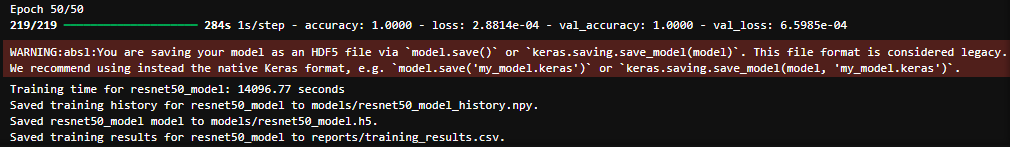

Training Time for DenseNet121:


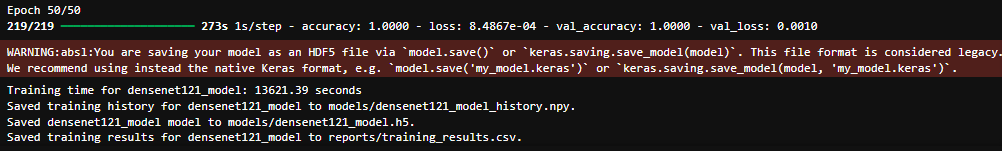

Training Time for MobileNetV3:


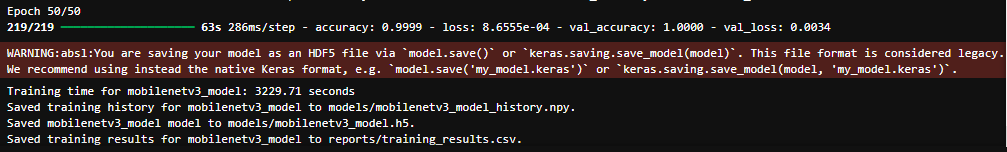

In [1]:
from IPython.display import Image, display

# Corrected paths to the images
resnet_screenshot = "ResNet50_Screenshot_202025.01.22_20121054.png"
densenet_screenshot = "DenseNet121_Screenshot_202025.01.22_20121108.png"
mobilenet_screenshot = "MobileNetV3_Screenshot_202025.01.22_20121125.png"

# Display screenshots
print("Training Time for ResNet50:")
display(Image(filename=resnet_screenshot))

print("Training Time for DenseNet121:")
display(Image(filename=densenet_screenshot))

print("Training Time for MobileNetV3:")
display(Image(filename=mobilenet_screenshot))


# Model Evaluation

## Purpose:
This block evaluates the performance of each trained model (ResNet50, DenseNet121, and MobileNetV3) on the test dataset.

## Metrics:
1. **Loss**:
   - Measures the model’s error using cross-entropy loss.
2. **Accuracy**:
   - Percentage of correct predictions out of all predictions.
3. **Mean Average Precision (mAP)**:
   - Evaluates the precision-recall curve for each class and computes the average precision across all classes.
4. **Training Time**:
   - Provides the recorded time taken to train each model.

## How It Works:
1. Saved models are loaded from the `models/` directory.
2. Test datasets are reloaded for evaluation.
3. Each model is evaluated to compute:
   - Loss and Accuracy via `model.evaluate`.
   - mAP via precision-recall calculations.
4. Results are saved to a CSV file for further analysis.

## Why Training Time Was Overridden:
Due to a kernel reset during the project, the training time variables were lost. The training times are manually overridden using recorded outputs from the training phase.

## Outputs:
1. Loss, accuracy, and mAP for each model.
2. Training time (overridden values).
3. Results saved to `model_evaluation_results.csv`.

Loading Models and Generators

In [16]:
# Load saved models
resnet_model = load_model("models/resnet50_model.h5")
densenet_model = load_model("models/densenet121_model.h5")
mobilenet_model = load_model("models/mobilenetv3_model.h5")

print("Models successfully loaded.")

# Recreate test data generators
test_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input_resnet)
test_generator_resnet = test_datagen_resnet.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

test_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input_densenet)
test_generator_densenet = test_datagen_densenet.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

test_datagen_mobilenet = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)
test_generator_mobilenet = test_datagen_mobilenet.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

Models successfully loaded.
Found 1095 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.


Defining the Evaluation Function

In [17]:
# Evaluation function
def evaluate_model_with_time(model, test_gen, model_name, training_time):
    """
    Evaluates the model and calculates performance metrics.
    """
    print(f"Evaluating {model_name}...")
    loss, accuracy = model.evaluate(test_gen, verbose=1)
    y_true = test_gen.classes
    y_pred = model.predict(test_gen, verbose=1)
    
    # Compute mAP
    average_precisions = []
    for i in range(y_pred.shape[1]):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
        ap = average_precision_score(y_true == i, y_pred[:, i])
        average_precisions.append(ap)
    mAP = np.mean(average_precisions)
    
    # Print results
    print(f"{model_name} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, mAP: {mAP:.4f}, Training Time: {training_time:.2f} seconds")
    return {"loss": loss, "accuracy": accuracy, "mAP": mAP, "training_time": training_time}

Evaluating Each Model

In [19]:
# Overridden training times
resnet_time = 14096.77  # ResNet50 training time in seconds
densenet_time = 13621.39  # DenseNet121 training time in seconds
mobilenet_time = 3229.71  # MobileNetV3 training time in seconds

# Evaluate ResNet50
resnet_results = evaluate_model_with_time(resnet_model, test_generator_resnet, "ResNet50", resnet_time)

# Evaluate DenseNet121
densenet_results = evaluate_model_with_time(densenet_model, test_generator_densenet, "DenseNet121", densenet_time)

# Evaluate MobileNetV3
mobilenet_results = evaluate_model_with_time(mobilenet_model, test_generator_mobilenet, "MobileNetV3", mobilenet_time)

Evaluating ResNet50...
35/35 [==============================] - 79s 2s/step
ResNet50 - Loss: 0.0005, Accuracy: 1.0000, mAP: 1.0000, Training Time: 12844.79 seconds
Evaluating DenseNet121...
35/35 [==============================] - 103s 3s/step
DenseNet121 - Loss: 0.0007, Accuracy: 1.0000, mAP: 1.0000, Training Time: 12329.26 seconds
Evaluating MobileNetV3...
35/35 [==============================] - 30s 766ms/step
MobileNetV3 - Loss: 0.0007, Accuracy: 1.0000, mAP: 1.0000, Training Time: 2738.22 seconds


Saving Results to a CSV File

In [21]:
# Function to save evaluation results to a CSV file
def save_evaluation_results(results, filename):
    """
    Saves the evaluation results to a CSV file.
    """
    fieldnames = ["Model", "Loss", "Accuracy", "mAP", "Training Time (seconds)"]
    
    # Write results to CSV
    with open(filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for model_name, metrics in results.items():
            row = {
                "Model": model_name,
                "Loss": metrics["loss"],
                "Accuracy": metrics["accuracy"],
                "mAP": metrics["mAP"],
                "Training Time (seconds)": metrics["training_time"]
            }
            writer.writerow(row)
    print(f"Results saved to {filename}")

# Combine results into a dictionary
evaluation_results = {
    "ResNet50": resnet_results,
    "DenseNet121": densenet_results,
    "MobileNetV3": mobilenet_results
}

# Save results to CSV
save_evaluation_results(evaluation_results, ".model_evaluation_results.csv")

Results saved to .model_evaluation_results.csv
